In [1]:
from astropy.io import fits
import numpy as np
import astropy.units as u
import astropy.constants as const


In [2]:
filename = 'cube_zodi10inc0dist3_epoch25.7300_sres150.000_0.6um.fits'
cube = fits.open(filename)[0].data

maxlam = 1.2
minlam = 0.6
R = 150
dlam = (maxlam+minlam)/2./R
lamlist = np.arange(minlam,maxlam,dlam)
dist_pc = 3
pix_scale_au = 0.057*dist_pc/4
asec_per_pix = pix_scale_au/dist_pc
res_asec = 0.057
OWA_880 = 0.076*20
OWA_pix = OWA_880/asec_per_pix


In [3]:
cube = cube*u.Jy

In [4]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)


In [5]:
minlam661 = (0.661-0.061/2.)*u.micron
maxlam661 = (0.661+0.061/2.)*u.micron
minlam721 = (0.721-0.036/2.)*u.micron
maxlam721 = (0.721+0.036/2.)*u.micron
minlam890 = (0.890-0.0445/2.)*u.micron
maxlam890 = (0.890+0.0445/2.)*u.micron
F661 = cube[np.where((lamlist>minlam661.value)*(lamlist<maxlam661.value))[0],:,:]
F721 = cube[np.where((lamlist>minlam721.value)*(lamlist<maxlam721.value))[0],:,:]
F890 = cube[np.where((lamlist>minlam890.value)*(lamlist<maxlam890.value))[0],:,:]
F661_flat = np.mean(F661,axis=0)
F721_flat = np.mean(F721,axis=0)
F890_flat = np.mean(F890,axis=0)

### Crop image and convert to photons per second    

In [6]:

xdim,ydim = F661_flat.shape
print (xdim,ydim)
xmin = xdim/2-OWA_pix
xmax = xdim/2+OWA_pix
ymin = ydim/2-OWA_pix
ymax = ydim/2+OWA_pix
F661 = F661_flat[xmin:xmax,ymin:ymax]
F721 = F721_flat[xmin:xmax,ymin:ymax]
F890 = F890_flat[xmin:xmax,ymin:ymax]


dnu661 = (const.c/minlam661).to(u.Hz) - (const.c/maxlam661).to(u.Hz)
dnu721 = (const.c/minlam721).to(u.Hz) - (const.c/maxlam721).to(u.Hz)
dnu890 = (const.c/minlam890).to(u.Hz) - (const.c/maxlam890).to(u.Hz)
ep661 = (const.h*const.c/(661*u.nm)).to(u.J)
ep721 = (const.h*const.c/(721*u.nm)).to(u.J)
ep890 = (const.h*const.c/(890*u.nm)).to(u.J)
A = np.pi*(2.4*u.m)**2/4.
F661*=dnu661/ep661*A
F721*=dnu721/ep721*A
F890*=dnu890/ep890*A
F661=F661.to(u.Hz)
F721=F721.to(u.Hz)
F890=F890.to(u.Hz)

export = np.zeros((3,F661.shape[0],F661.shape[1]))
export [0,:,:] += F661.value
export [1,:,:] += F721.value
export [2,:,:] += F890.value


301 301


/Users/mrizzo/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:913: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = super(Quantity, self).__getitem__(key)


In [7]:
F661.shape

(214, 214)

In [8]:
out = fits.PrimaryHDU(F661.value)
out.writeto('F661.fits',clobber=True)
out = fits.PrimaryHDU(export)
out.writeto(filename+'proc.fits',clobber=True)
out = fits.PrimaryHDU(F721.value)
out.writeto('F721.fits',clobber=True)
out = fits.PrimaryHDU(F890.value)
out.writeto('F890.fits',clobber=True)

In [9]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


In [10]:
import os
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data')
import webbpsf
from webbpsf import wfirst
import ipywidgets
import poppy.utils as utils
import poppy
import logging as log

In [11]:
webbpsf.setup_logging('ERROR') # Reduced verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


In [12]:
def xy_to_psf(x, y, quad_cube):
    hw = quad_cube.shape[-1] // 2
    if x >= hw and y >= hw: # in first quadrant
        s = (y - hw)*hw + (x - hw)
        return quad_cube[s]
    elif x < hw and y >= hw: # second quadrant
        s = (y - hw)*hw + (hw - x - 1)
        return quad_cube[s,:,::-1]
    elif x < hw and y < hw: # third quadrant
        s = (hw - y - 1)*hw + (hw - x - 1)
        return quad_cube[s,::-1,::-1]
    else:                 # fourth quadrant
        s = (hw - y - 1)*hw + (x - hw)
        return quad_cube[s,::-1,:]

In [13]:
fov = 3.4 # arcsec
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F72
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode)
diskspc.options['source_offset_r'] = 0 # arcsec
diskspc.options['source_offset_theta'] = 0 # deg w.r.t. North

filter_fname = diskspc._filters[diskspc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)

print('{:.1f}% bandpass centered at {:.1f} nm'.format(
100*float(filter_hdulist[1].header.get('DELTALAM'))/float(filter_hdulist[1].header.get('LAMBDA0')),
float(filter_hdulist[1].header.get('LAMBDA0'))/10))

lamoD_asec_F661 = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*diskspc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D): %.5f arcsec" % lamoD_asec_F661)

10.0% bandpass centered at 661.0 nm
System diffraction resolution element scale (lambda_0/D): 0.05681 arcsec


In [14]:
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F721'
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)

# Load input cube

[  3.74777644e+09   2.11167963e+09   2.16418894e+09]
(3, 212, 212)


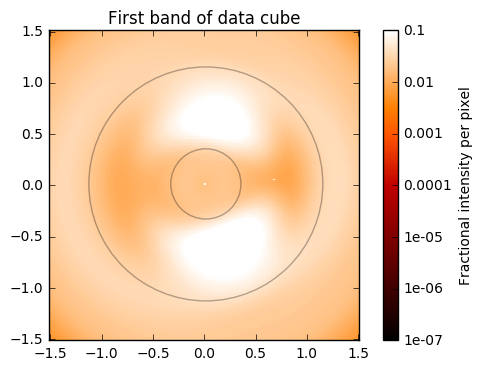

In [15]:
haystacks = fits.open(filename+'proc.fits')

#define adjustable cropping factor
border=1
input_cube = haystacks[0].data[:,border:-border,border:-border]#[:,90:-90,90:-90]#[:2,580:-580,580:-580]

haystacks[0].header["INFITS"] = filename+'proc.fits'
haystacks[0].header["PIXELSCL"] = asec_per_pix
haystacks[0].header["BUNIT"] = "Jy"

#location of center from Ds9 inspection
'''
DS9 coordinate notes, corners are from 0.5-213.5 and center is at 108.

in numpy coordinates the center is at 107,107

'''

center = (107-border)
print(input_cube[:,center,center])
print(input_cube.shape)

# find parameters:
dim = input_cube.shape

ny = dim[1]
nx = dim[2]
haystacks[0].header



haystack_1stBand = fits.HDUList([fits.PrimaryHDU(input_cube[0],
                                                 header=haystacks[0].header)])
ax=plt.subplot(111)
poppy.display_PSF(haystack_1stBand,
                  interpolation='nearest',ax=ax)
circle2 = plt.Circle((0.015, 0.015), 0.057*6, color='black', fill=False,alpha=0.3)
circle3 = plt.Circle((0.015, 0.015), 0.057*20, color='black', fill=False,alpha=0.3)

ax.add_artist(circle2)
ax.add_artist(circle3)


plt.title("First band of data cube")



In [16]:
contrast_floor=1e-11
# thresh=contrast_floor*input_cube[:,center,center]
thresh=np.zeros(3)
# n_thresh=[cube[np.where(input_cube[i]>thresh[i])].size for i in range(len(thresh))]
print (thresh)

[ 0.  0.  0.]


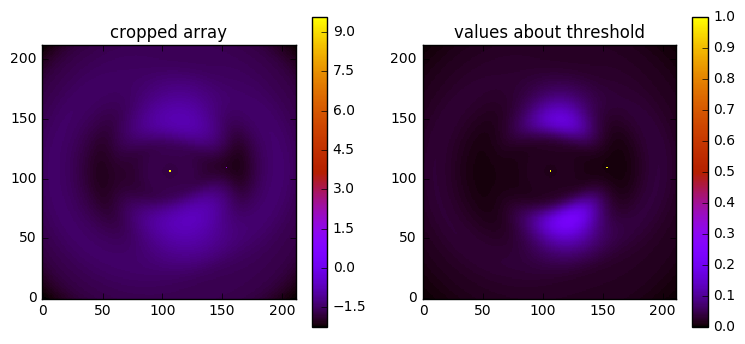

In [17]:
plt.figure(figsize=[9,4])
plt.subplot(121)
plt.title("cropped array")
plt.imshow(np.log10(input_cube[0]),
           cmap=plt.cm.gnuplot,
           origin = 'lower',
           interpolation='nearest')
plt.colorbar()
plt.subplot(122)
plt.title("values about threshold")
plt.imshow(input_cube[0],cmap=plt.cm.gnuplot,
           interpolation='nearest',
           vmin=thresh[0],
           origin = 'lower',vmax=1)
plt.colorbar()


In [18]:
mode_list = ['DISKSPC_F661','DISKSPC_F721','DISKSPC_F883']
lib_list = ['offax_psf_map_DISKSPC_F661.fits.gz','offax_psf_map_DISKSPC_F721.fits.gz','offax_psf_map_DISKSPC_F883.fits.gz']

In [22]:
ho_OPD_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/OPD/CGI_static_test_OPD_D256_120pm.fits")

OPD_header = fits.getheader(ho_OPD_fname)
OPD_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
BUNIT   = 'meter   '                                                            

In [77]:
wavelength_imgs = []
on_axis_psfs_ref=[]
on_axis_psfs_obs=[]
Nt = 100
OPD_factor = 5
for i in range(len(mode_list)):
    mode = mode_list[i]
    print('Processing mode ' + mode)
    libpsf = fits.getdata(lib_list[i])
    scratch_psf = xy_to_psf(0,0,libpsf)
    
    inputImage = input_cube[i,:,:]
    # same scale for all bands
    
    diskspc = wfirst.CGI(mode=mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)
    opd_cube_fname = '{:s}_OPD_cube_Nwf{:d}.fits.gz'.format(diskspc.mode, Nt)
    opd = fits.getdata(opd_cube_fname)/OPD_factor
    onax_psf_ref=np.zeros(scratch_psf.shape)
    onax_psf_obs=np.zeros(scratch_psf.shape)
    # the loop over time represents different realizations of the wavefront errors
    # use the first 50 for the reference star, the last 50 for the observation
    print("Looping over times")
    for t in range(Nt):
        if t%10==0: print(t)
        diskspc.pupilopd = fits.HDUList([fits.PrimaryHDU(opd[t], header=OPD_header)])
        _, diskspc_onax_ab_wfs = diskspc.calc_psf(display=False, return_intermediates=True,
                                                  fov_arcsec=fov)
        if t<50:
            onax_psf_ref += diskspc_onax_ab_wfs[-1].intensity
        else:
            onax_psf_obs += diskspc_onax_ab_wfs[-1].intensity
    on_axis_psfs_ref.append(onax_psf_ref/50.*inputImage[center,center])
    on_axis_psfs_obs.append(onax_psf_obs/50.*inputImage[center,center])
    
    
    
    outputImage = np.zeros(scratch_psf.shape)
    center_libpsf = 240//2
    
    # now loop over all relevant pixels
    print("Looping over the off-axis pixels")
    for x in range(-nx//2,-nx//2+nx):
        for y in range(-ny//2,-ny//2+ny):
            if x==0 and y==0:
                print("Adding the central star")
                psf = onax_psf_obs/50.
            else:
                psf = xy_to_psf(x+center_libpsf,y+center_libpsf,libpsf)
            outputImage += inputImage[y+center,x+center]*psf
            
    wavelength_imgs.append(outputImage)
outcube = np.zeros((3,wavelength_imgs[0].shape[0],wavelength_imgs[0].shape[1]))    
obscube = np.zeros((3,wavelength_imgs[0].shape[0],wavelength_imgs[0].shape[1]))    
refcube = np.zeros((3,wavelength_imgs[0].shape[0],wavelength_imgs[0].shape[1]))    


Processing mode DISKSPC_F661
Looping over times
0
10
20
30
40
50
60
70
80
90
Looping over the off-axis pixels
Adding the central star
Processing mode DISKSPC_F721
Looping over times
0
10
20
30
40
50
60
70
80
90
Looping over the off-axis pixels
Adding the central star
Processing mode DISKSPC_F883
Looping over times
0
10
20
30
40
50
60
70
80
90
Looping over the off-axis pixels
Adding the central star


In [78]:
# wavelength_imgs.append(np.zeros(scratch_psf.shape))
# wavelength_imgs.append(np.zeros(scratch_psf.shape))
# on_axis_psfs_ref.append(np.zeros(scratch_psf.shape))
# on_axis_psfs_ref.append(np.zeros(scratch_psf.shape))
# on_axis_psfs_obs.append(np.zeros(scratch_psf.shape))
# on_axis_psfs_obs.append(np.zeros(scratch_psf.shape))

for i in range(len(mode_list)):
    obscube[2-i,:,:] = wavelength_imgs[i]   
    refcube[2-i,:,:] = on_axis_psfs_ref[i]    
    outcube[2-i,:,:] = on_axis_psfs_obs[i]   
out = fits.HDUList([fits.PrimaryHDU(data=obscube)])
out.writeto(filename+'obscube.fits',clobber=True)
out = fits.HDUList([fits.PrimaryHDU(data=refcube)])
out.writeto(filename+'refcube.fits',clobber=True)
out = fits.HDUList([fits.PrimaryHDU(data=refcube)])
out.writeto(filename+'outcube.fits',clobber=True)

# add detector binning and Poisson noise

In [79]:
eff = 1.0 # overall CGI efficiency not captured by PSF model
tottime = np.array([6*3600,3*3600,3*3600])
#nframes = 1000
#tint = tottime/float(nframes) # tot int time per frame
tint = np.array([100,100,100]) # tot int time per frame
nframes = tottime/tint
nframes=nframes.astype(np.int)
print(nframes)
rebinfact = 2 # rebinning factor
dark = 0.0#5e-4
CIC=0.0#3e-3
RN = 0.2
krist_factor=[0.46,0.46,0.46]

obscube = fits.getdata(filename+'obscube.fits')
refcube = fits.getdata(filename+'refcube.fits')
outcube2 = np.zeros((obscube.shape[0],obscube.shape[1]//rebinfact,obscube.shape[2]//rebinfact))
refcube2 = np.zeros((obscube.shape[0],obscube.shape[1]//rebinfact,obscube.shape[2]//rebinfact))
print(outcube2.shape)
finalcube = np.zeros(outcube2.shape)
finalvariance = np.zeros(outcube2.shape)
for i in range(outcube.shape[0]):
    outcube2[i,:,:] = rebin(obscube[i,:,:],(obscube.shape[1]//rebinfact,obscube.shape[2]//rebinfact))*krist_factor[i]*tint[i]
    refcube2[i,:,:] = rebin(refcube[i,:,:],(obscube.shape[1]//rebinfact,obscube.shape[2]//rebinfact))*krist_factor[i]*tint[i]
    for n in range(nframes[i]):
        val = np.random.poisson(outcube2[i,:,:]+dark*tint[i]+CIC)+np.random.poisson(RN)
        finalcube[i,:,:] += val
        finalvariance[i,:,:] += val**2
#         val = np.random.poisson(outcube2[j,:,:]+dark*tint[i]+CIC)+np.random.poisson(RN)
#         finalcube[j,:,:] += outcube2[j,:,:]
#         finalvariance[j,:,:] += val**2
# for j in range(outcube.shape[0]):
#     finalcube[j,:,:] = np.random.poisson(outcube2[j,:,:]+dark*tint+CIC)+np.random.poisson(RN)
    finalcube[i] /= nframes[i]
    finalvariance[i] /= nframes[i]
    finalvariance[i] -= finalcube[i]**2

out = fits.HDUList([fits.PrimaryHDU(data=finalcube)])
#out.append(fits.PrimaryHDU(data=finalvariance))
out.writeto('obs.fits',clobber=True)
out = fits.HDUList([fits.PrimaryHDU(data=refcube2)])
out.writeto('ref.fits',clobber=True)
finalcube -= refcube2
out = fits.HDUList([fits.PrimaryHDU(data=finalcube)])
out.writeto('final.fits',clobber=True)


[216 108 108]
(3, 120, 120)


# Create RGB image

In [62]:
import aplpy

In [80]:
aplpy.make_rgb_image('final.fits','test_rgb.png',vmin_r=-40,vmax_r=40,vmin_g=-40,vmax_g=40,vmin_b=-40,vmax_b=40)

INFO: Red: [aplpy.rgb]
[astropy] Red:
INFO: vmin = -4.000e+01 [aplpy.rgb]
[astropy] vmin = -4.000e+01
INFO: vmax =  4.000e+01 [aplpy.rgb]
[astropy] vmax =  4.000e+01
INFO: Green: [aplpy.rgb]
[astropy] Green:
INFO: vmin = -4.000e+01 [aplpy.rgb]
[astropy] vmin = -4.000e+01
INFO: vmax =  4.000e+01 [aplpy.rgb]
[astropy] vmax =  4.000e+01
INFO: Blue: [aplpy.rgb]
[astropy] Blue:
INFO: vmin = -4.000e+01 [aplpy.rgb]
[astropy] vmin = -4.000e+01
INFO: vmax =  4.000e+01 [aplpy.rgb]
[astropy] vmax =  4.000e+01


/Users/mrizzo/anaconda/lib/python3.5/site-packages/aplpy/rgb.py:218: UserWarning: PyAVM 0.9.1 or later is not installed, so AVM tags will not be embedded in RGB image
  warnings.warn("PyAVM 0.9.1 or later is not installed, so AVM tags will not be embedded in RGB image")


In [82]:
cubeRGB = fits.getdata('final1.fits')
out = fits.HDUList([fits.PrimaryHDU(data=cubeRGB[0,:,:])])
out.writeto('R.fits',clobber=True)
out = fits.HDUList([fits.PrimaryHDU(data=cubeRGB[1,:,:])])
out.writeto('G.fits',clobber=True)
out = fits.HDUList([fits.PrimaryHDU(data=cubeRGB[2,:,:])])
out.writeto('B.fits',clobber=True)
